In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import pytensor.tensor as pt

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

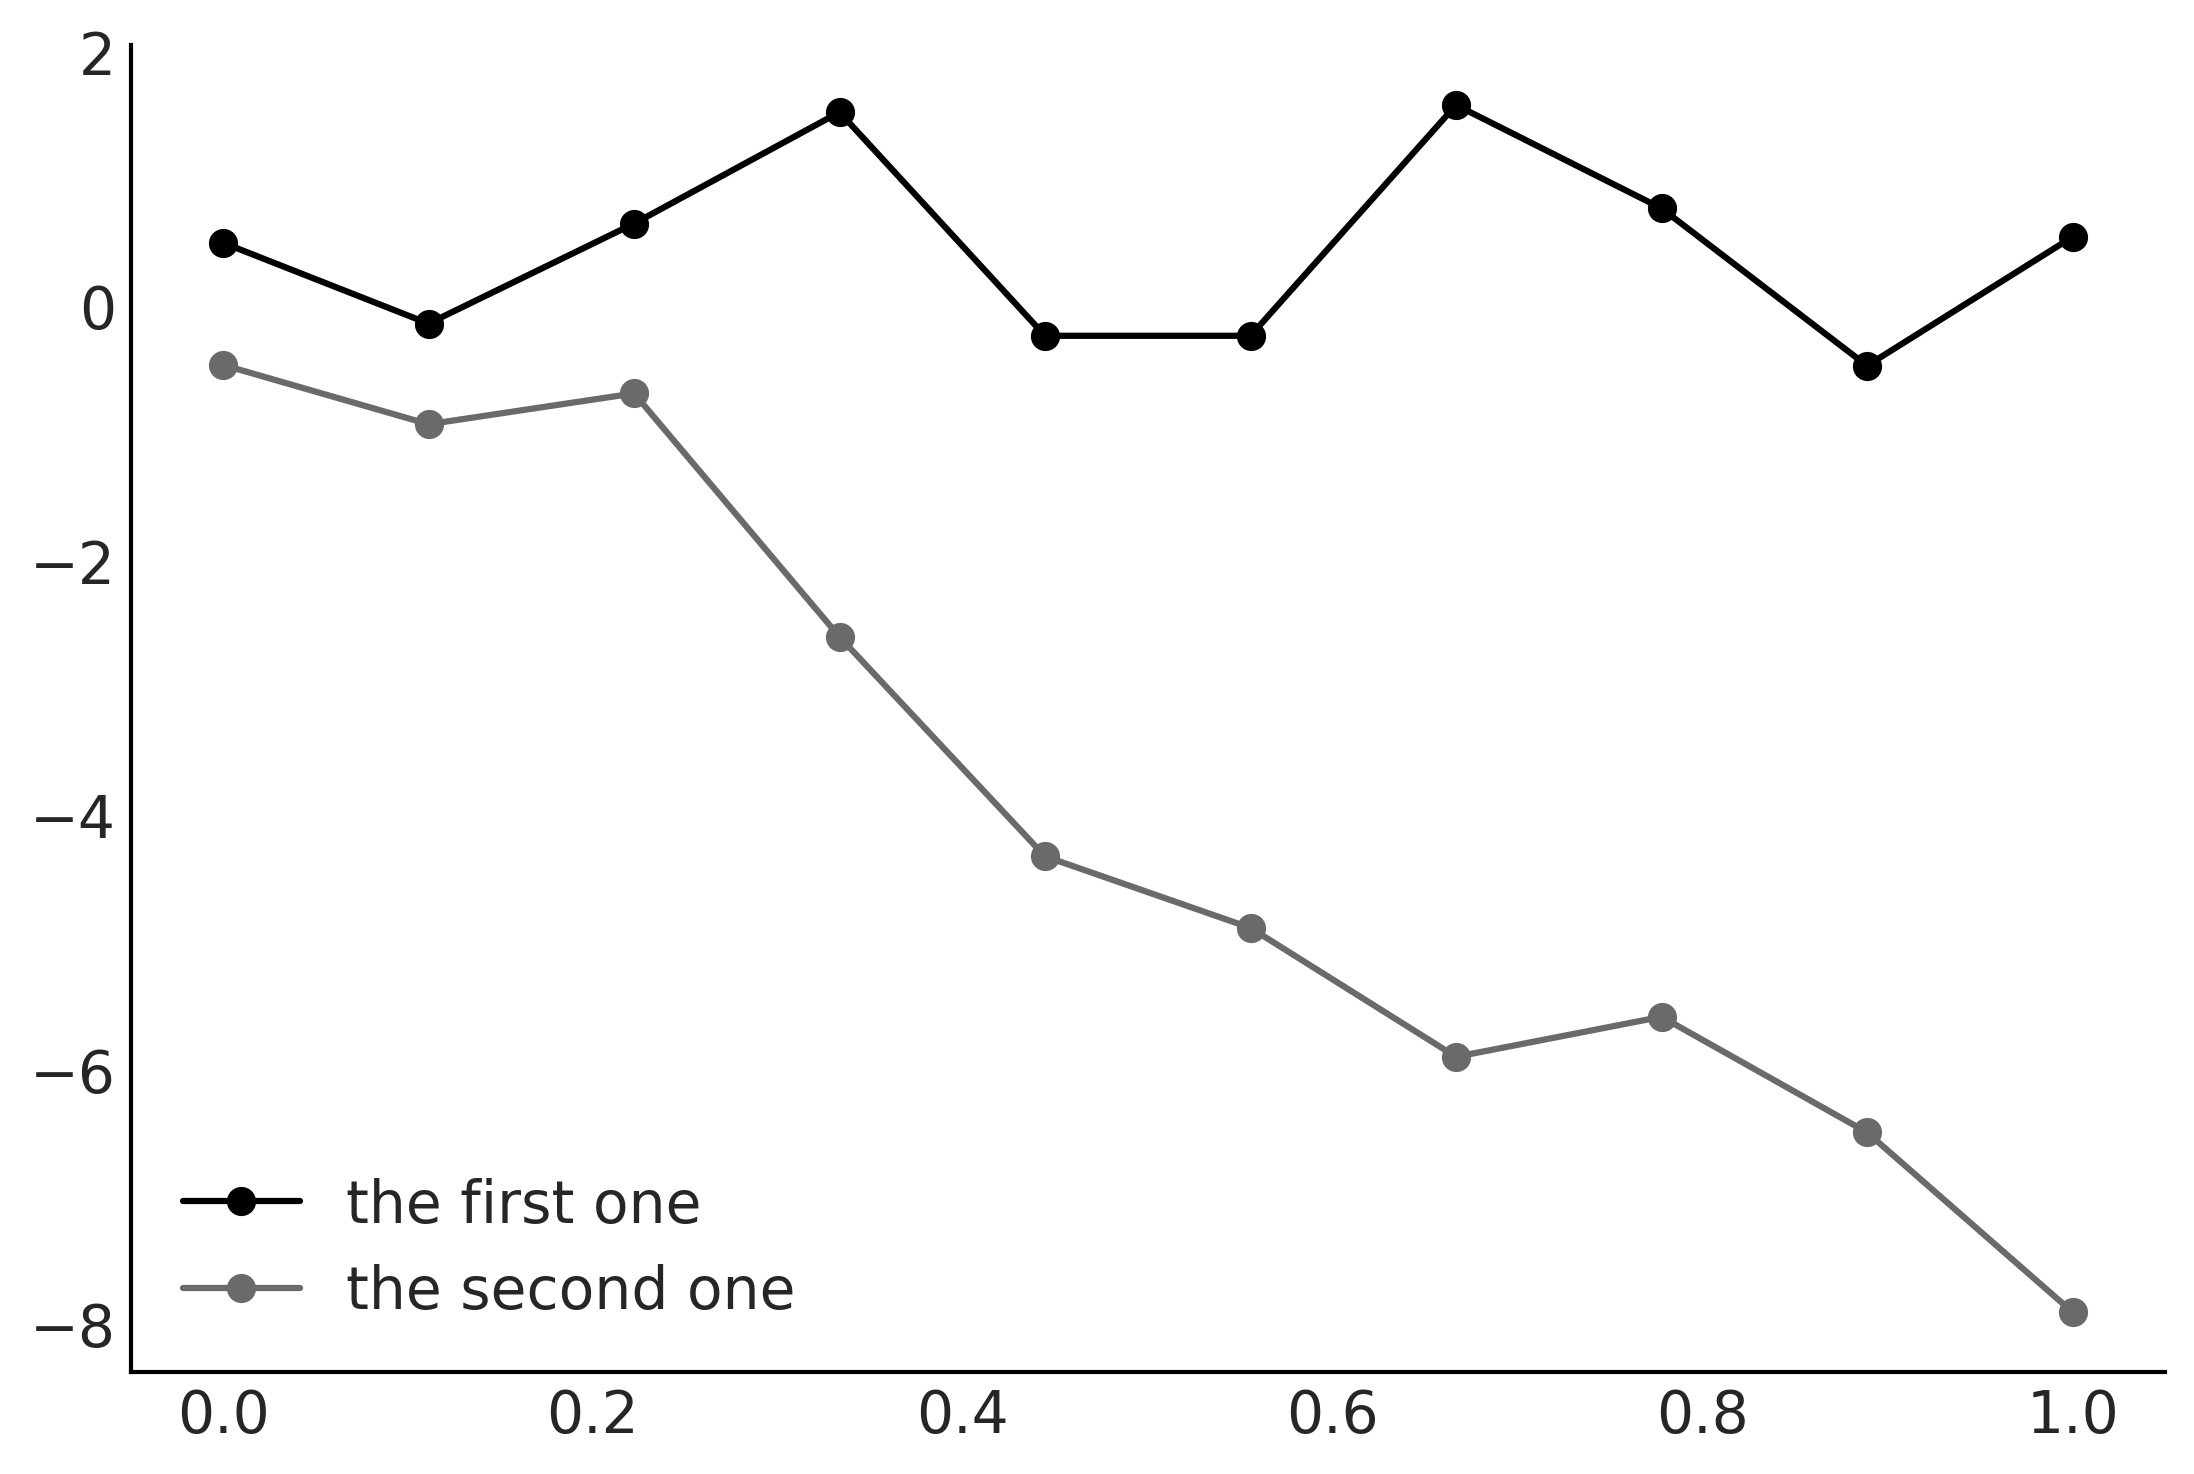

In [3]:
np.random.seed(42)
x = np.linspace(0, 1, 10)

y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label='the first one')

y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')

plt.legend()
plt.savefig('../fig/dummy_functions.png')

### Covariance functions and kernels

In [4]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

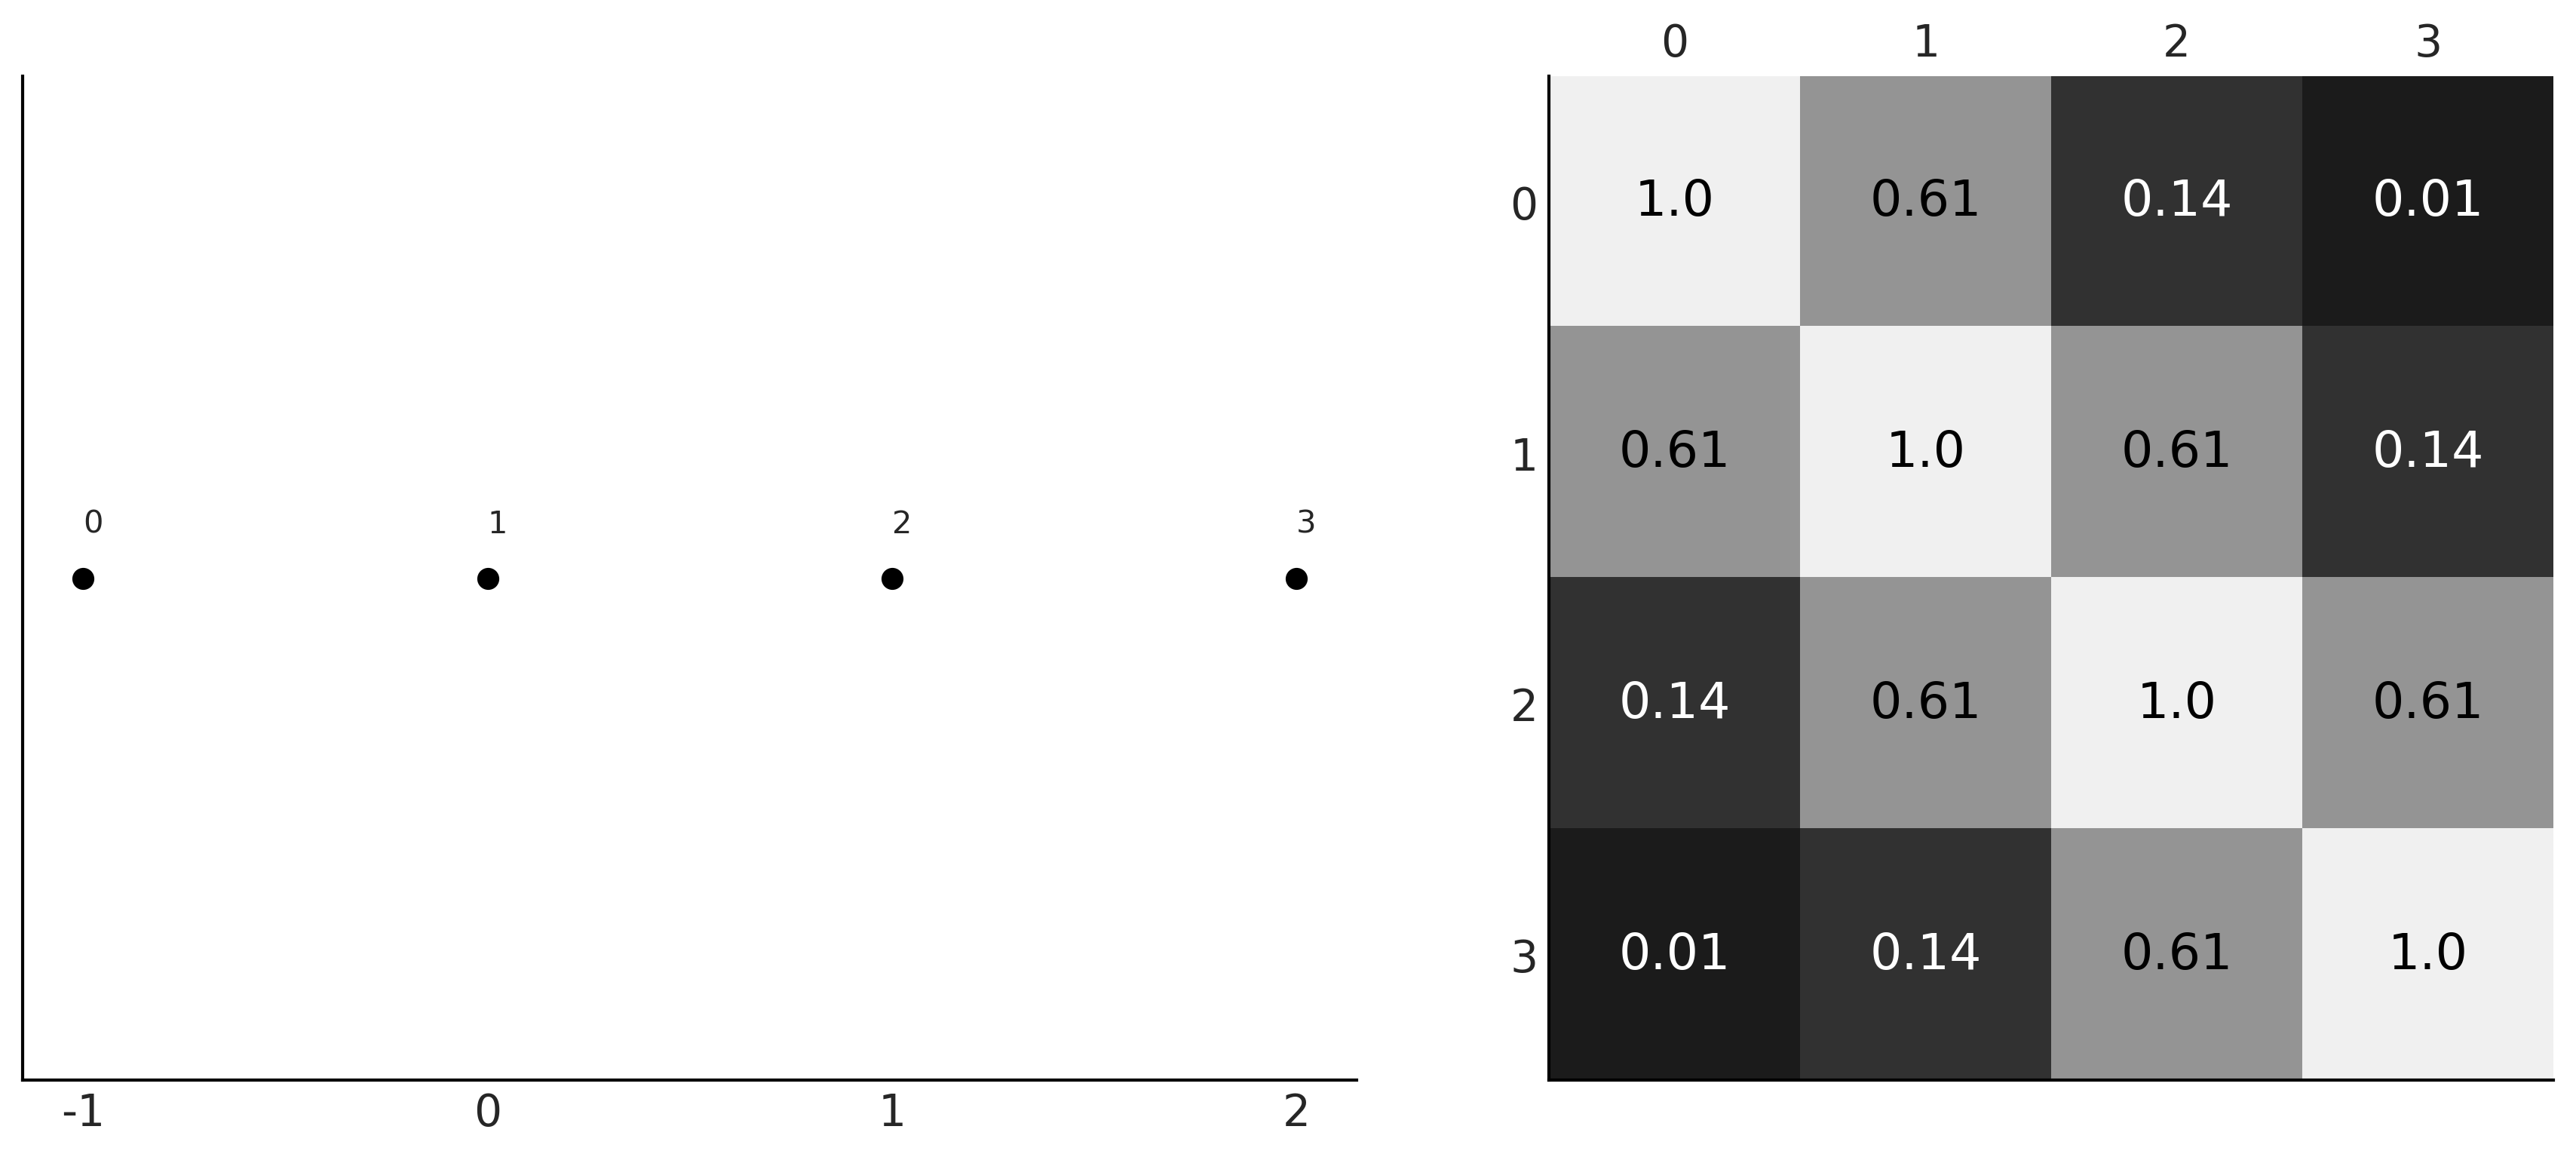

In [5]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()
plt.savefig('../fig/dummy_cov.png')

NameError: name 'stats' is not defined

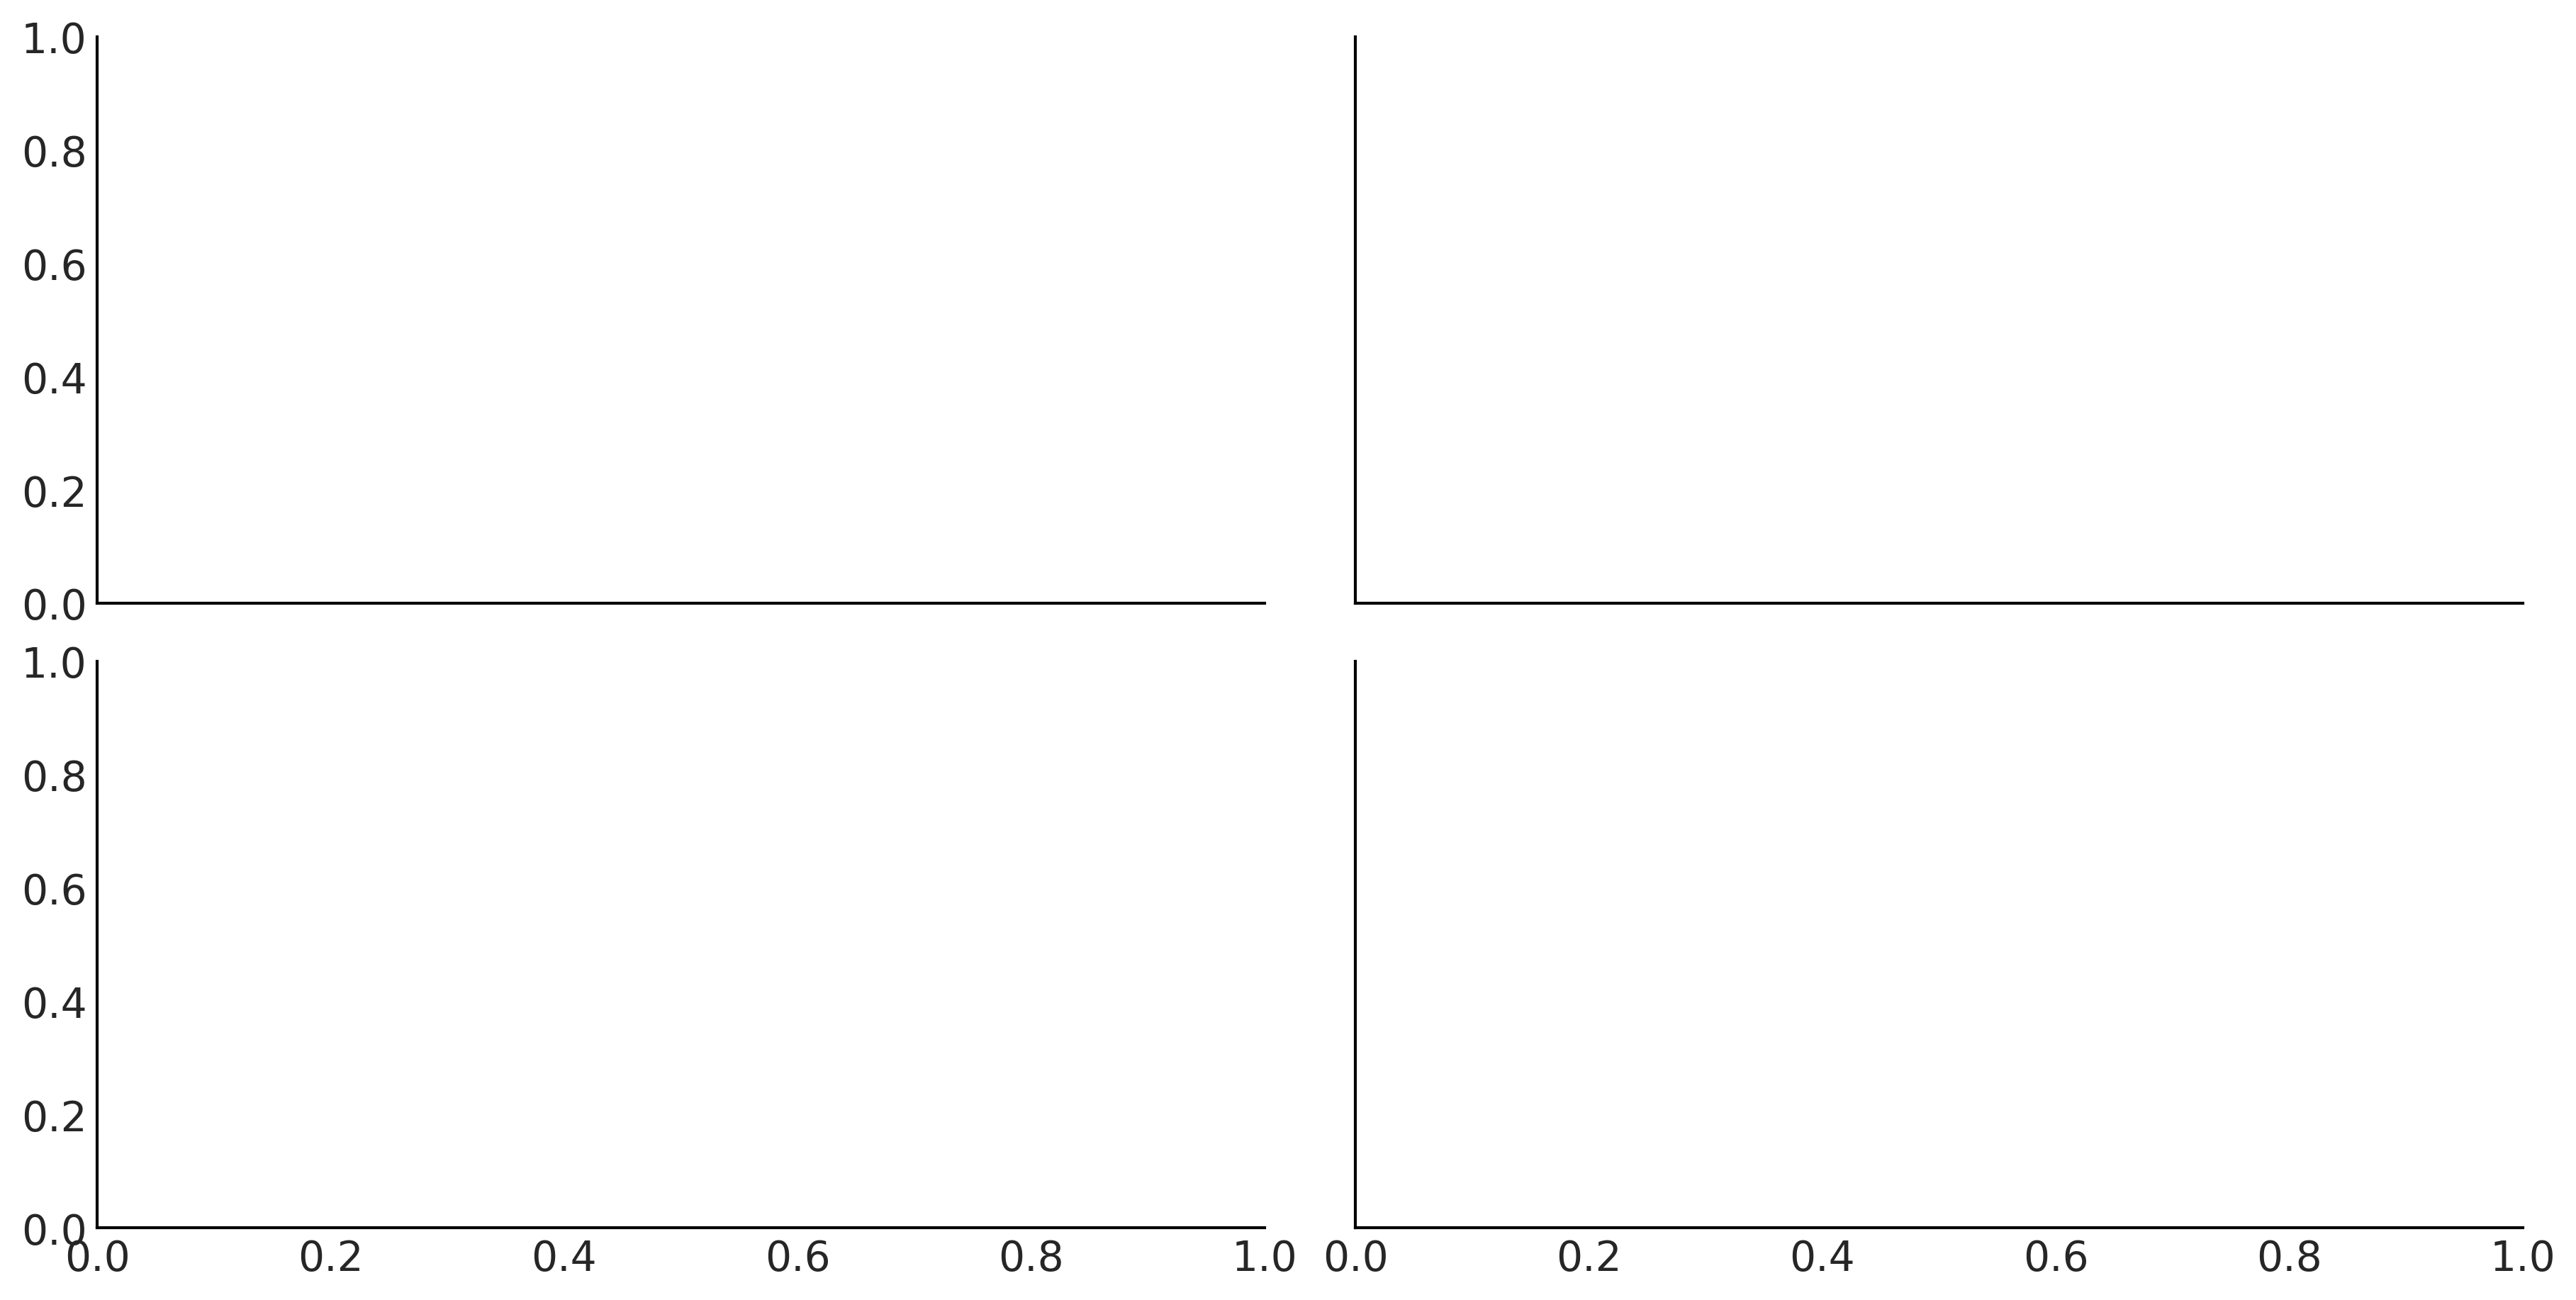

In [6]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True,
                       sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)
plt.savefig('../fig/dummy_realizations.png')

## Gaussian Process regression

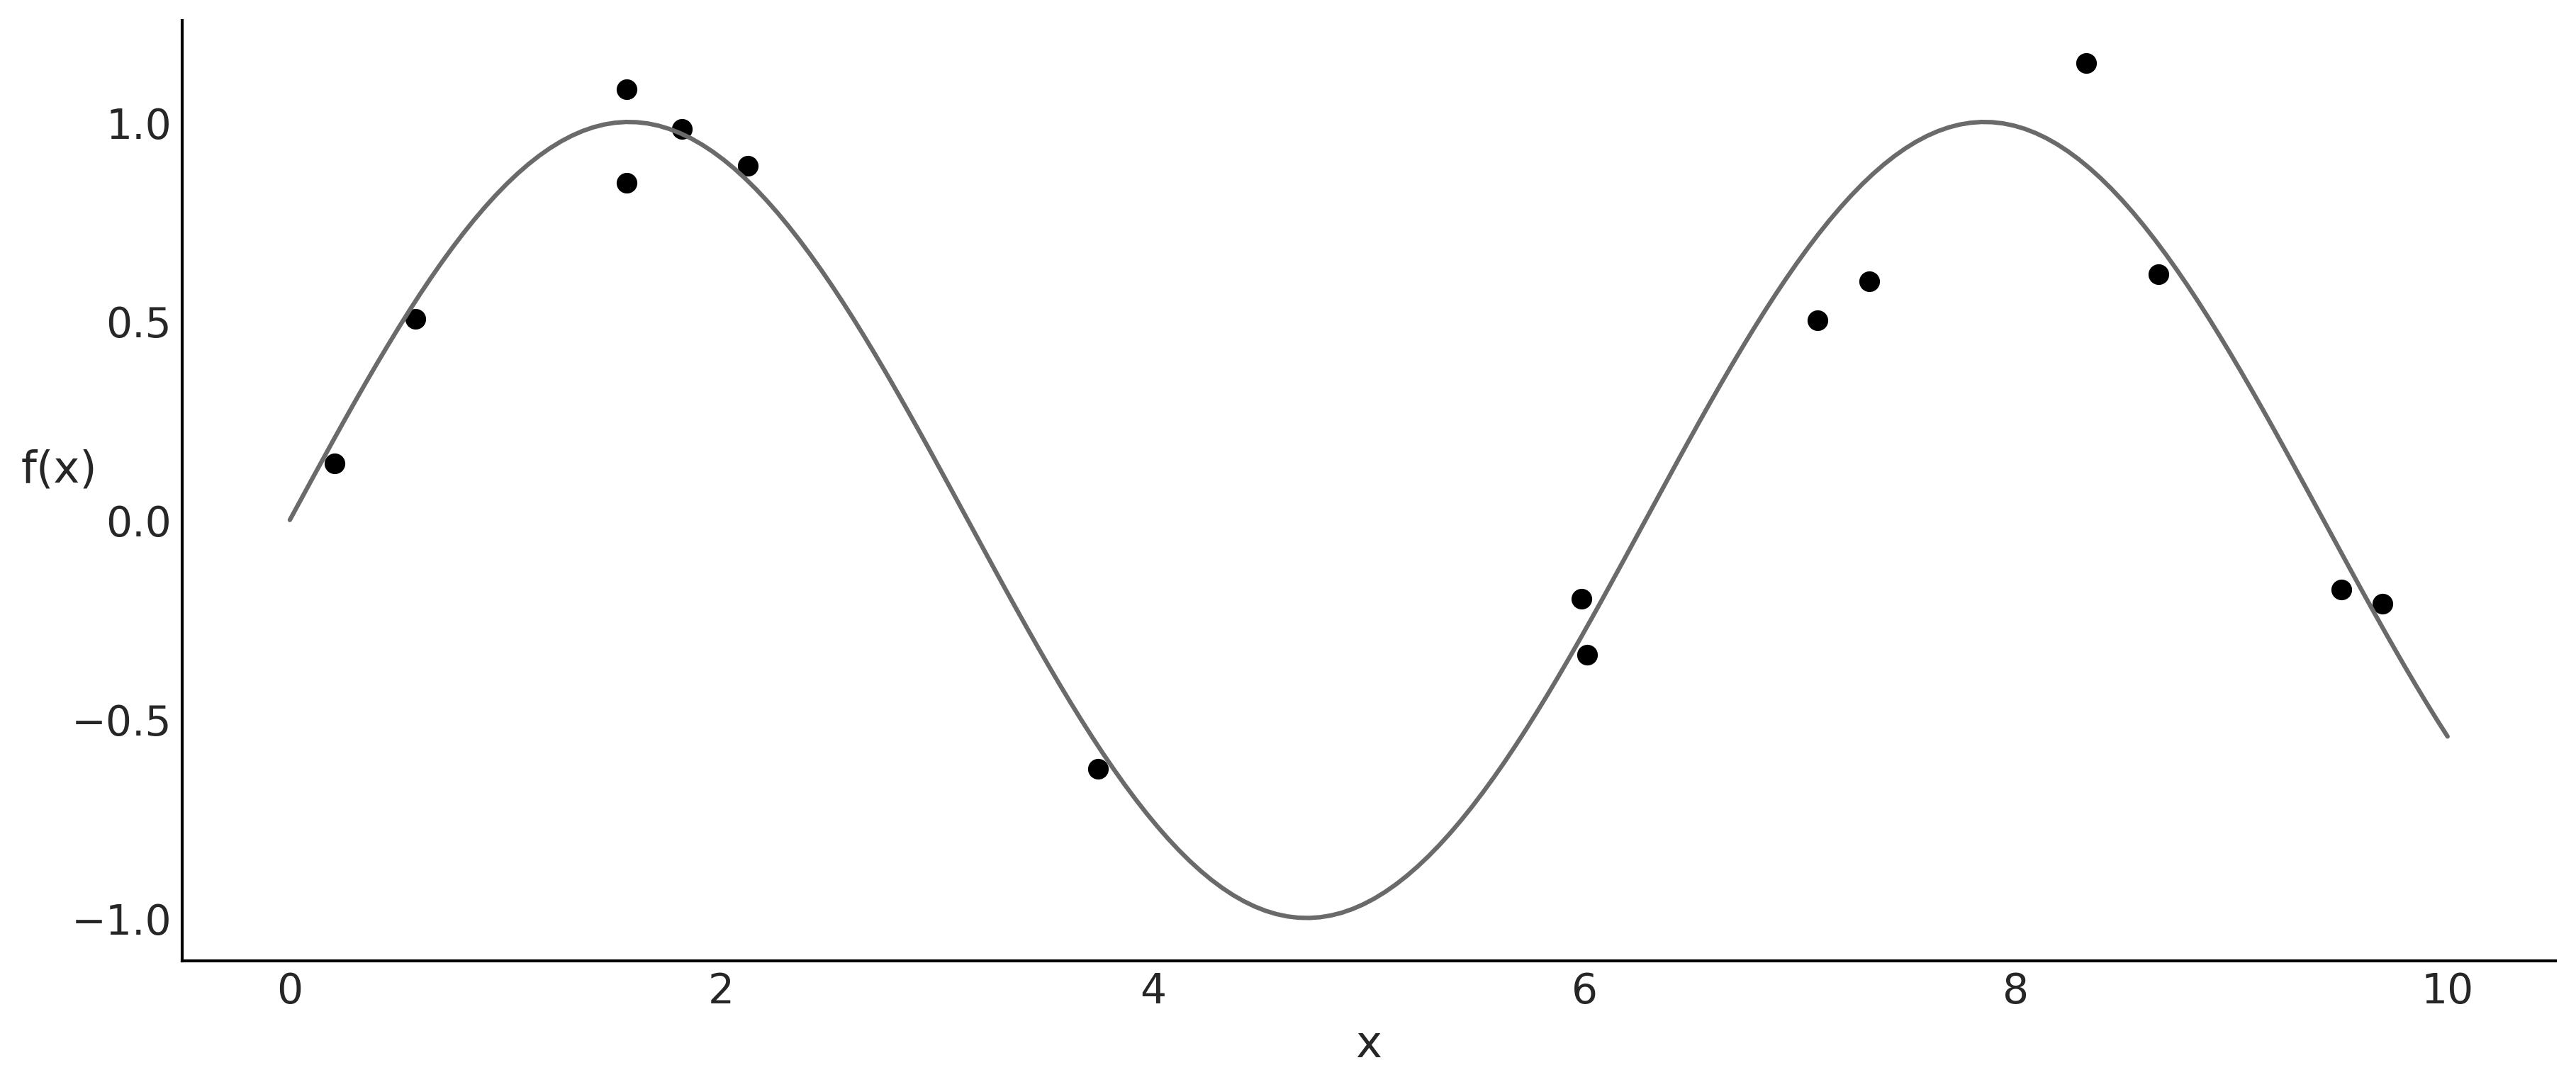

In [ ]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)

_, ax = plt.subplots(figsize=(12,5))


ax.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
ax.plot(true_x, np.sin(true_x), 'C1')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0)
plt.savefig('../fig/fake_sin.png')

In [ ]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, sigma=ϵ)
    idata_reg = pm.sample(2000)

/home/osvaldo/proyectos/00_BM/pymc/pymc/gp/gp.py:54: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.


In [8]:
#az.plot_trace(idata_reg)
#plt.savefig('B11197_07_05.png')

In [ ]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    #del marginal_gp_model.named_vars['f_pred']
    #marginal_gp_model.vars.remove(f_pred)
    f_pred = gp.conditional('f_pred', X_new)

In [ ]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(idata_reg.sel(draw=slice(0, None, 100)), var_names=["f_pred"])

f_pred = pred_samples.posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].values

Sampling: [f_pred]


Text(0.5, 0, 'X')

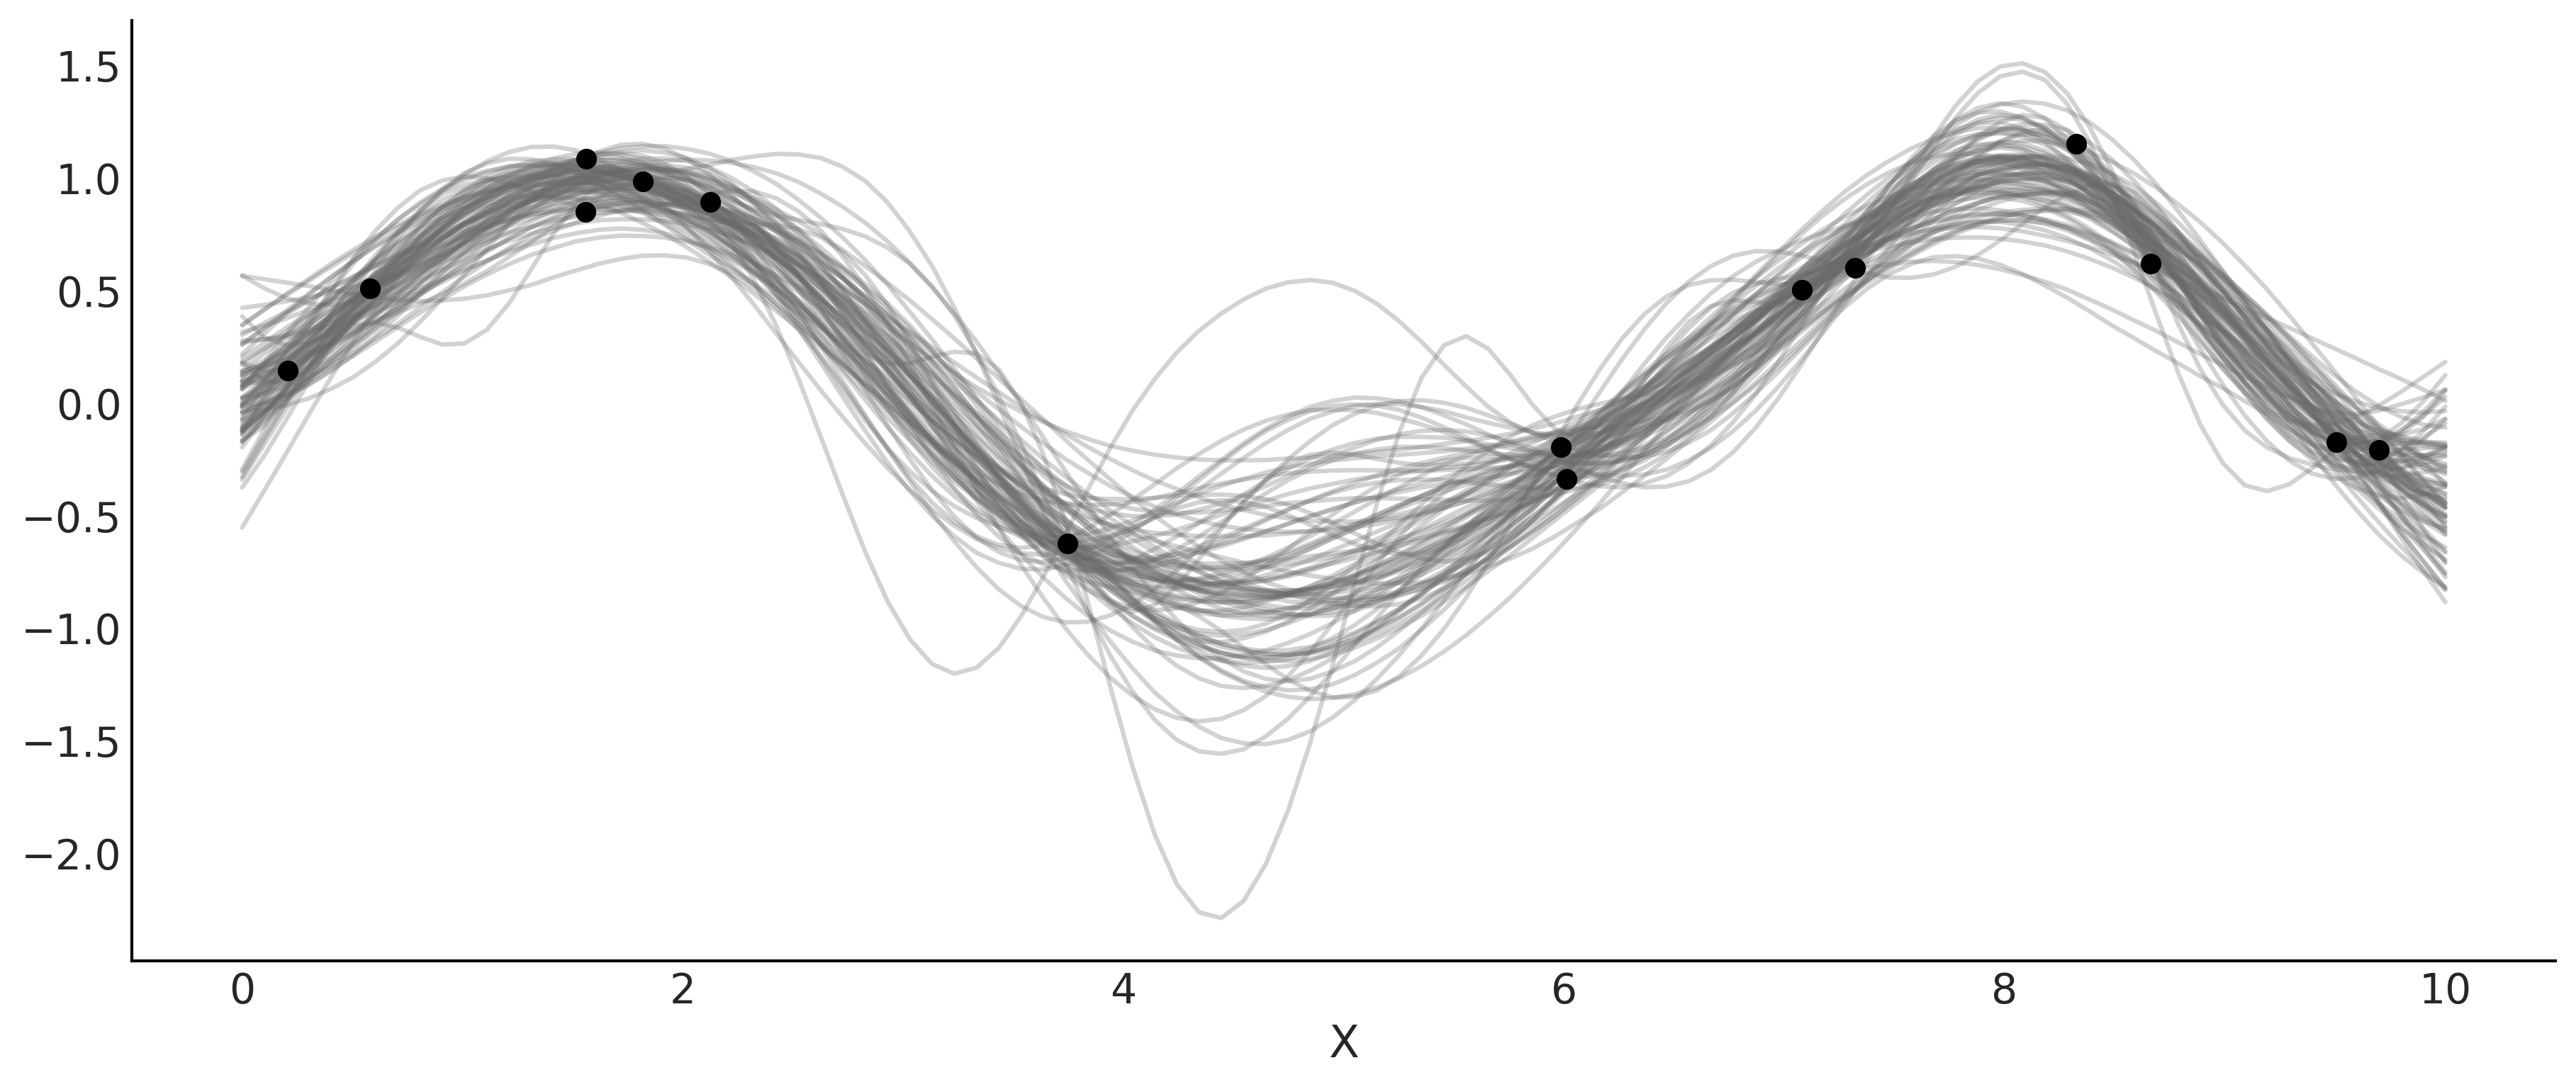

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, f_pred, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('../fig/GP_sd_fit_lines.png')

Text(0, 0.5, 'f(x)')

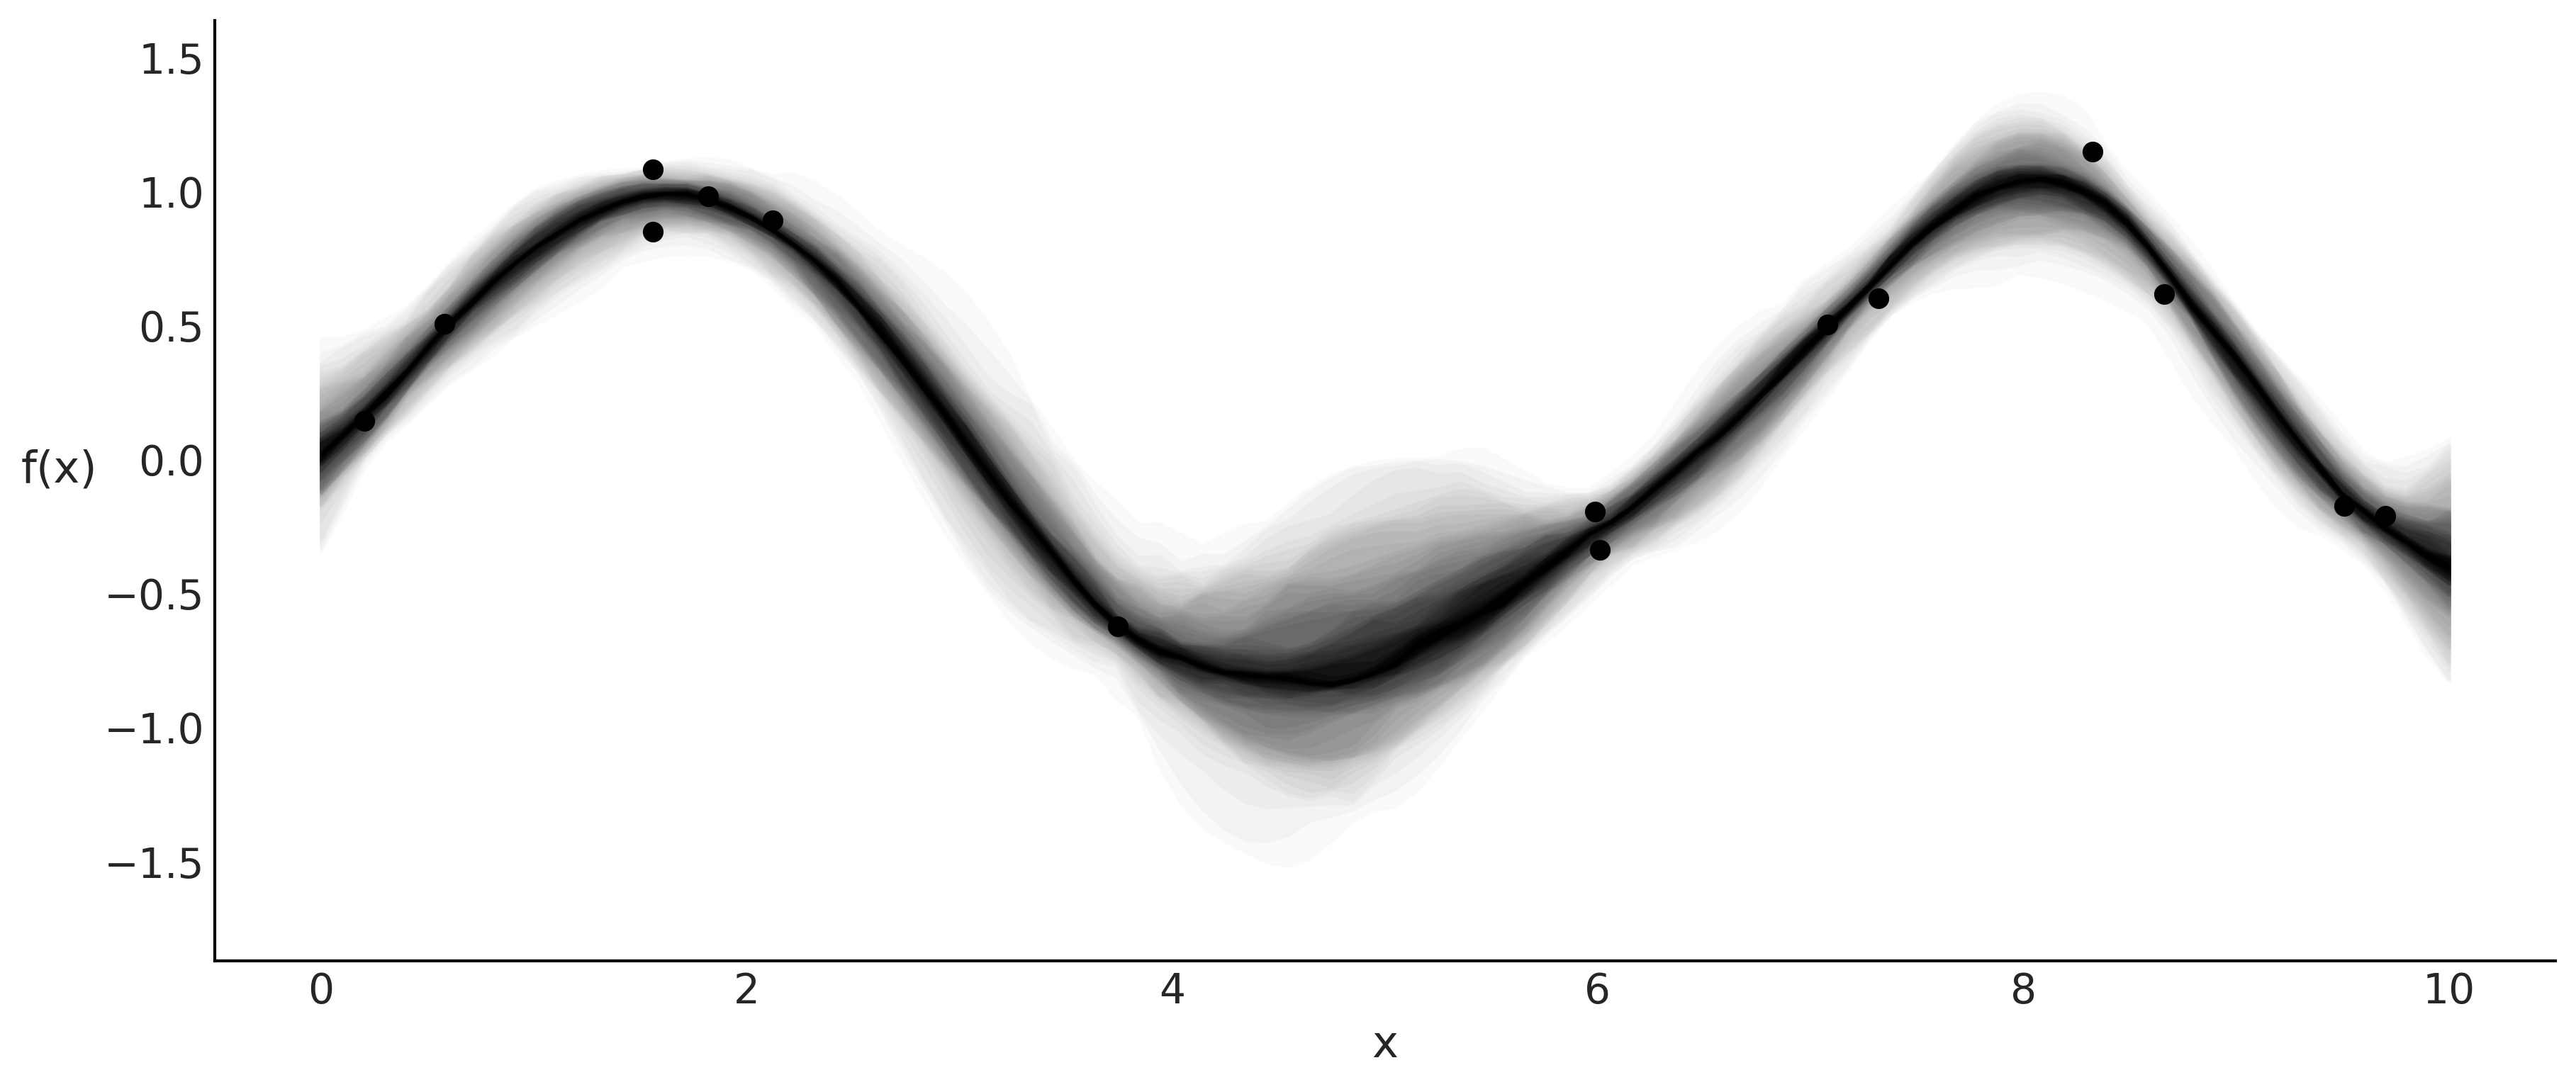

In [ ]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, f_pred.T, X_new, palette='gray_r', plot_samples=False);

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)
plt.savefig('../fig/GP_sd_fit_dist.png')

Text(0.5, 0, 'X')

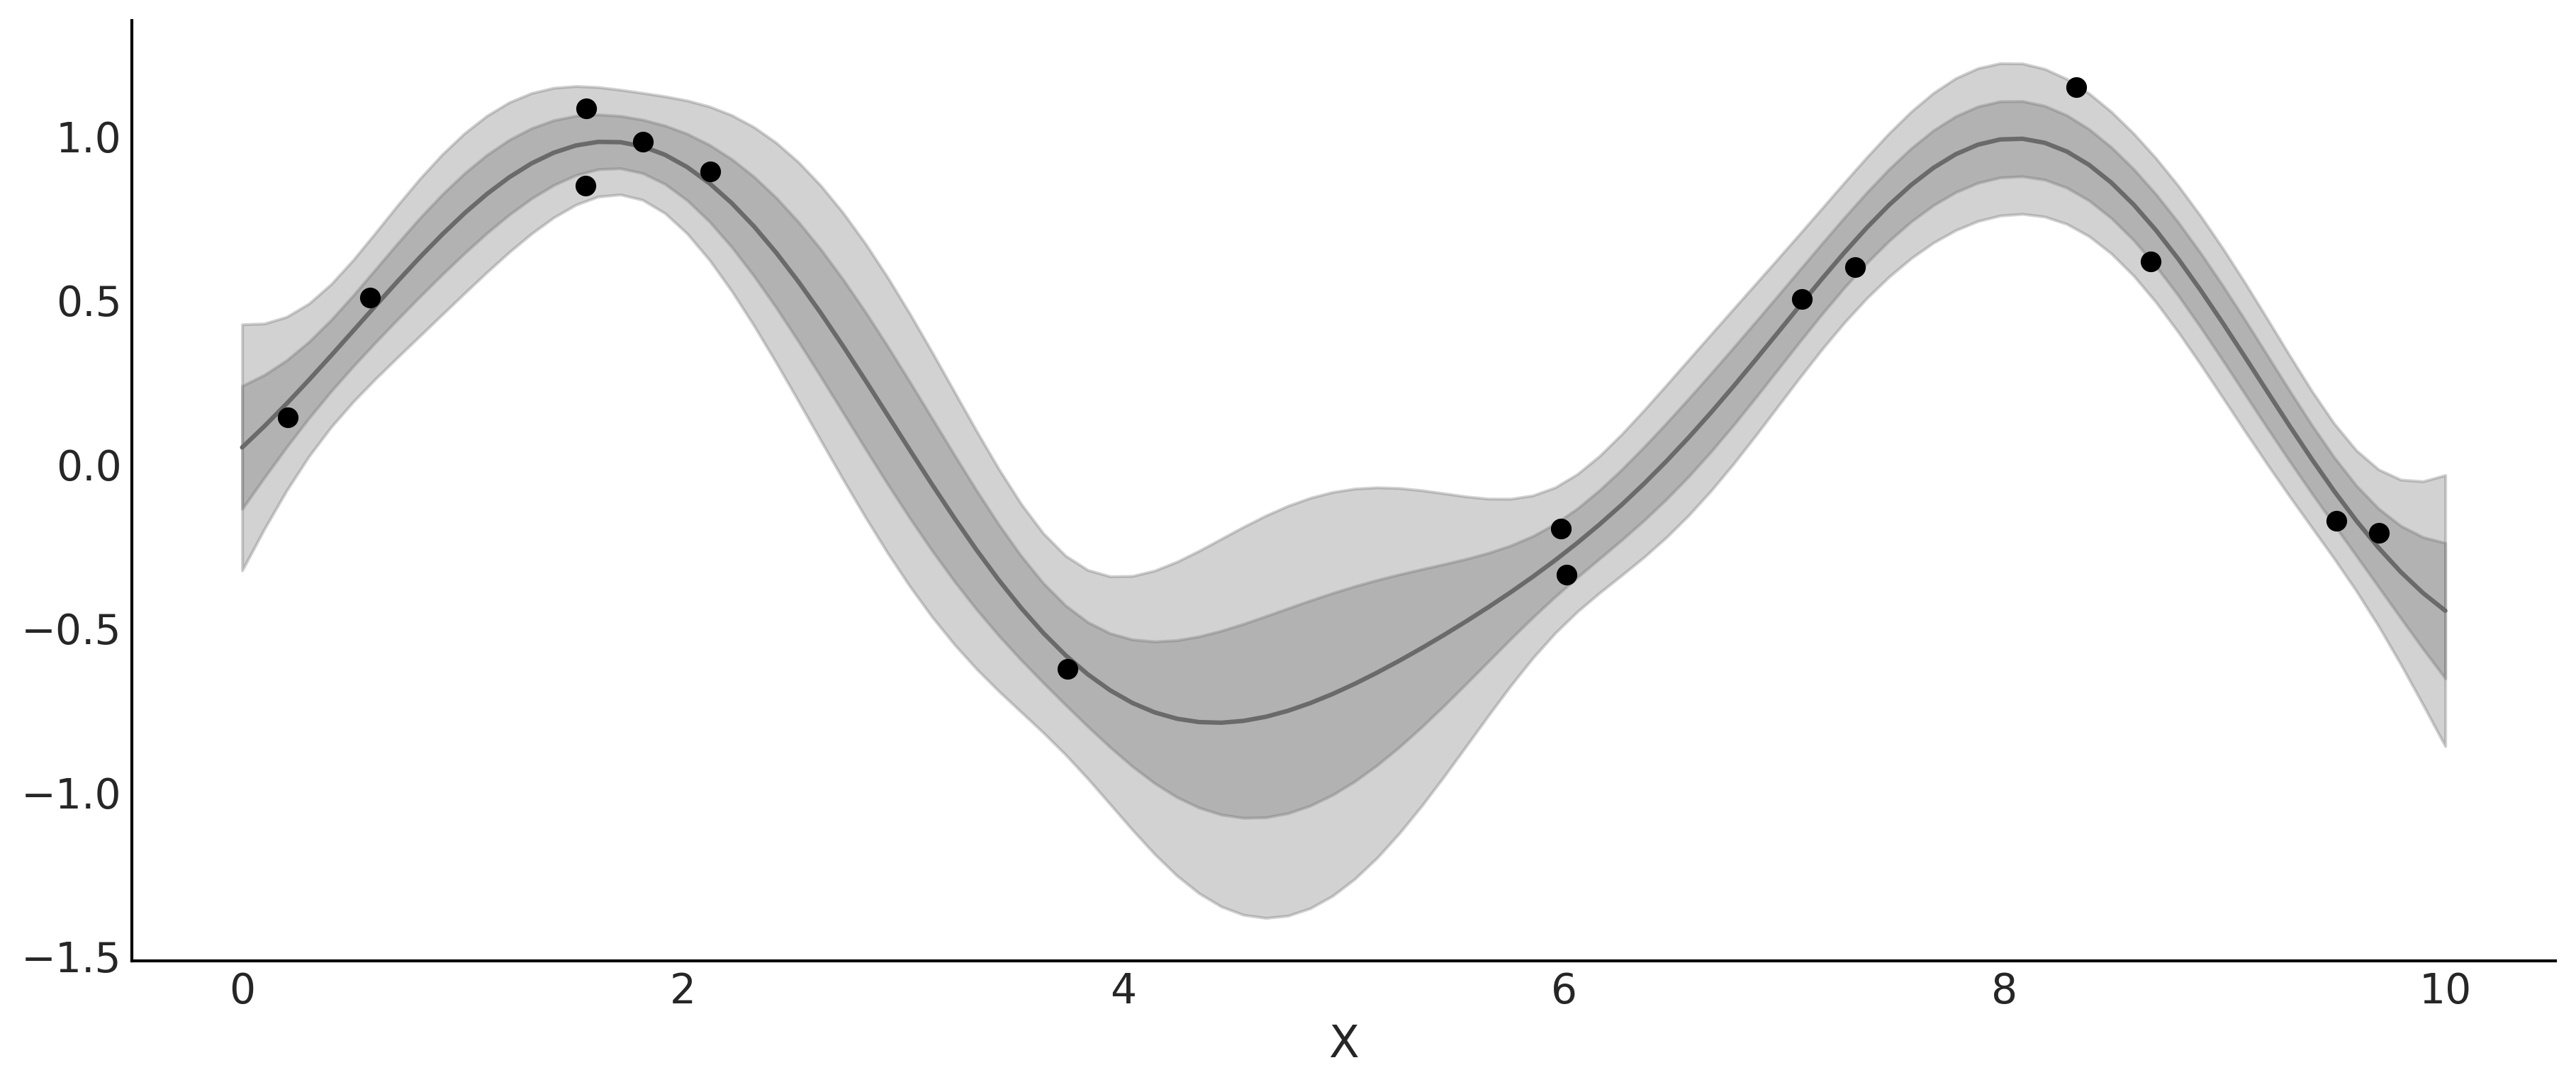

In [ ]:
# plot the results
_, ax = plt.subplots(figsize=(12,5))

# predict
point = {'ℓ': idata_reg.posterior['ℓ'].mean(), 'ϵ': idata_reg.posterior['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True,  model=model_reg)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('../fig/GP_sd_fit_bands.png')

In [ ]:
daf

## Regression with spatial autocorrelation

In [ ]:
islands_dist = pd.read_csv('../data/islands_dist.csv',
                           sep=',', index_col=0)
islands_dist.round(1)

In [ ]:
islands = pd.read_csv('../data/islands.csv', sep=',')
islands.head().round(1)

In [ ]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [ ]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)

    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    idata_islands = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

In [ ]:
#az.summary(idata_islands, var_names=['α', 'β', 'η', 'ℓ', 'f'])

In [ ]:
posterior_islands = idata_islands.posterior.stack(samples=("chain", "draw"))
trace_η = posterior_islands['η'].values
trace_ℓ = posterior_islands['ℓ'].values

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)

ax.plot(xrange, np.median(trace_η) *
        np.exp(-np.median(trace_ℓ) * xrange**2), lw=3)

ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_ℓ[::20][:, None] * xrange**2)).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')
plt.savefig('B11197_07_09.png')

In [ ]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=islands_dist.columns, columns=islands_dist.columns)
ρ.round(2)

In [ ]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(posterior_islands['α'].values[:, None] +
                     posterior_islands['β'].values[:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)


ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hdi(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
            plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})


for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')


ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)
plt.savefig('B11197_07_10.png')

### Gaussian process classification

In [ ]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

In [ ]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [ ]:
with pm.Model() as model_iris:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris = pm.sample(1000, return_inferencedata=True)

In [ ]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with model_iris:

    f_pred = gp.conditional('f_pred', X_new) 
    pred_samples = pm.sample_posterior_predictive(idata_iris, var_names=["f_pred"], samples=1000)

In [ ]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp, color='C2')

db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_11.png')

In [ ]:
with pm.Model() as model_iris2:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris2 = pm.sample(1000, chains=1, compute_convergence_checks=False, return_inferencedata=True)

In [ ]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(idata_iris2,
                                                  var_names=["f_pred"],
                                                  samples=1000)

In [ ]:
_, ax = plt.subplots(figsize=(10,6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.scatter(x_1, np.random.normal(y, 0.02), marker='.', color=[f'C{ci}' for ci in y])

db = np.array([find_midpoint(f, X_new[:,0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)

ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hdi(X_new[:,0], fp, color='C2')

ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_12.png')

In [ ]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu

ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
plt.savefig('B11197_07_13.png', bbox_inches='tight')

In [ ]:
with pm.Model() as model_space_flu:
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    idata_space_flu = pm.sample(1000, chains=1, compute_convergence_checks=False, return_inferencedata=True)

In [ ]:
X_new = np.linspace(0, 80, 200)[:, None]

with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(idata_space_flu,
                                                  var_names=["f_pred"],
                                                  samples=1000)

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.nanmean(fp, 0)

ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)

az.plot_hdi(X_new[:, 0], fp, color='C2')
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')
plt.savefig('B11197_07_14.png')

### the coal-mining disaster

In [ ]:
coal_df = pd.read_csv('../data/coal.csv', header=None)
coal_df.head()

In [ ]:
# discretize data
years = int(coal_df.max().values - coal_df.min().values)
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [ ]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)

    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    idata_coal = pm.sample(1000, chains=1, return_inferencedata=True)

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

f_trace = np.exp(idata_coal.posterior['f'].stack(samples=("chain", "draw")).T)
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hdi(x_centers, f_trace)

az.plot_hdi(x_centers, f_trace, hdi_prob=0.5,
            plot_kwargs={'alpha': 0})

ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')
plt.savefig('B11197_07_15.png')

### the redwood data

In [ ]:
rw_df = pd.read_csv('../data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')
plt.savefig('B11197_07_16.png')

In [ ]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

In [ ]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ',  rw_df.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])

    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)

    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    idata_rw = pm.sample(1000, return_inferencedata=True)

In [ ]:
az.summary(idata_rw, var_names=['ℓ'])

In [ ]:
rate = np.exp(np.mean(idata_rw.posterior['f'].stack(samples=("chain", "draw")).T, axis=0).values.reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)
plt.savefig('B11197_07_17.png')

In [ ]:
#  def linear_kernel(x, knots):
#      """ linear kernel """
#     return np.array([(x - 2) * (k - 2) for k in knots])

In [ ]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()
plt.savefig('B11197_07_02.png')

In [ ]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True,
                       sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)
plt.savefig('B11197_07_03.png')

## Gaussian Process regression

In [ ]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)
plt.savefig('B11197_07_04.png')

In [ ]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    idata_reg = pm.sample(2000, return_inferencedata=True)

In [ ]:
az.plot_trace(idata_reg)
plt.savefig('B11197_07_05.png')

In [ ]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    #del marginal_gp_model.named_vars['f_pred']
    #marginal_gp_model.vars.remove(f_pred)
    f_pred = gp.conditional('f_pred', X_new)

In [ ]:
with model_reg:
    pred_samples = pm.sample_posterior_predictive(idata_reg, var_names=["f_pred"], samples=82)

In [ ]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, pred_samples['f_pred'].T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('B11197_07_06.png')

In [ ]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, pred_samples['f_pred'], X_new, palette='viridis', plot_samples=False);

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)
plt.savefig('B11197_07_07.png')

In [ ]:
# plot the results
_, ax = plt.subplots(figsize=(12,5))

# predict
point = {'ℓ': idata_reg.posterior['ℓ'].mean(), 'ϵ': idata_reg.posterior['ϵ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('B11197_07_08.png')

## Regression with spatial autocorrelation

In [ ]:
islands_dist = pd.read_csv('../data/islands_dist.csv',
                           sep=',', index_col=0)
islands_dist.round(1)

In [ ]:
islands = pd.read_csv('../data/islands.csv', sep=',')
islands.head().round(1)

In [ ]:
islands_dist_sqr = islands_dist.values**2
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [ ]:
with pm.Model() as model_islands:
    η = pm.HalfCauchy('η', 1)
    ℓ = pm.HalfCauchy('ℓ', 1)
    
    cov = η * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=islands_dist_sqr)

    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + f[index] + β * log_pop)
    tt_pred = pm.Poisson('tt_pred', μ, observed=total_tools)
    idata_islands = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)

In [ ]:
#az.summary(idata_islands, var_names=['α', 'β', 'η', 'ℓ', 'f'])

In [ ]:
posterior_islands = idata_islands.posterior.stack(samples=("chain", "draw"))
trace_η = posterior_islands['η'].values
trace_ℓ = posterior_islands['ℓ'].values

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, islands_dist.values.max(), 100)

ax.plot(xrange, np.median(trace_η) *
        np.exp(-np.median(trace_ℓ) * xrange**2), lw=3)

ax.plot(xrange, (trace_η[::20][:, None] * np.exp(- trace_ℓ[::20][:, None] * xrange**2)).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')
plt.savefig('B11197_07_09.png')

In [ ]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-np.median(trace_ℓ) * islands_dist_sqr))
# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=islands_dist.columns, columns=islands_dist.columns)
ρ.round(2)

In [ ]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(posterior_islands['α'].values[:, None] +
                     posterior_islands['β'].values[:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon2, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon2[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)


ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hdi(log_pop_seq, lambda_post, fill_kwargs={'alpha':0},
            plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})


for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon2[i], islands.lon2[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')


ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)
plt.savefig('B11197_07_10.png')

### Gaussian process classification

In [ ]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

In [ ]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [ ]:
with pm.Model() as model_iris:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris = pm.sample(1000, return_inferencedata=True)

In [ ]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with model_iris:

    f_pred = gp.conditional('f_pred', X_new) 
    pred_samples = pm.sample_posterior_predictive(idata_iris, var_names=["f_pred"], samples=1000)

In [ ]:
def find_midpoint(array1, array2, value):
    """
    This should be a proper docstring :-)
    """
    array1 = np.asarray(array1)
    idx0 = np.argsort(np.abs(array1 - value))[0]
    idx1 = idx0 - 1 if array1[idx0] > value else idx0 + 1
    if idx1 == len(array1):
        idx1 -= 1
    return (array2[idx0] + array2[idx1]) / 2

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp, color='C2')

db = np.array([find_midpoint(f, X_new[:, 0], 0.5) for f in fp])
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='k', alpha=0.5)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_11.png')

In [ ]:
with pm.Model() as model_iris2:
    #ℓ = pm.HalfCauchy("ℓ", 1)
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris2 = pm.sample(1000, chains=1, compute_convergence_checks=False, return_inferencedata=True)

In [ ]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(idata_iris2,
                                                  var_names=["f_pred"],
                                                  samples=1000)

In [ ]:
_, ax = plt.subplots(figsize=(10,6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.mean(fp, 0)

ax.scatter(x_1, np.random.normal(y, 0.02), marker='.', color=[f'C{ci}' for ci in y])

db = np.array([find_midpoint(f, X_new[:,0], 0.5) for f in fp])
db_mean = db.mean()
db_hpd = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='k')
ax.fill_betweenx([0, 1], db_hpd[0], db_hpd[1], color='k', alpha=0.5)

ax.plot(X_new[:,0], fp_mean, 'C2', lw=3)
az.plot_hdi(X_new[:,0], fp, color='C2')

ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('B11197_07_12.png')

In [ ]:
df_sf = pd.read_csv('../data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu

ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
plt.savefig('B11197_07_13.png', bbox_inches='tight')

In [ ]:
with pm.Model() as model_space_flu:
    ℓ = pm.HalfCauchy('ℓ', 1)
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    idata_space_flu = pm.sample(1000, chains=1, compute_convergence_checks=False, return_inferencedata=True)

In [ ]:
X_new = np.linspace(0, 80, 200)[:, None]

with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(idata_space_flu,
                                                  var_names=["f_pred"],
                                                  samples=1000)

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(pred_samples['f_pred'])
fp_mean = np.nanmean(fp, 0)

ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)

az.plot_hdi(X_new[:, 0], fp, color='C2')
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')
plt.savefig('B11197_07_14.png')

### the coal-mining disaster

In [ ]:
coal_df = pd.read_csv('../data/coal.csv', header=None)
coal_df.head()

In [ ]:
# discretize data
years = int(coal_df.max().values - coal_df.min().values)
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [ ]:
with pm.Model() as model_coal:
    ℓ = pm.HalfNormal('ℓ', x_data.std())
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)

    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    idata_coal = pm.sample(1000, chains=1, return_inferencedata=True)

In [ ]:
_, ax = plt.subplots(figsize=(10, 6))

f_trace = np.exp(idata_coal.posterior['f'].stack(samples=("chain", "draw")).T)
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hdi(x_centers, f_trace)

az.plot_hdi(x_centers, f_trace, hdi_prob=0.5,
            plot_kwargs={'alpha': 0})

ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')
plt.savefig('B11197_07_15.png')

### the redwood data

In [ ]:
rw_df = pd.read_csv('../data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 8))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')
plt.savefig('B11197_07_16.png')

In [ ]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten()

In [ ]:
with pm.Model() as model_rw:
    ℓ = pm.HalfNormal('ℓ',  rw_df.std().values, shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])

    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)

    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    idata_rw = pm.sample(1000, return_inferencedata=True)

In [ ]:
az.summary(idata_rw, var_names=['ℓ'])

In [ ]:
rate = np.exp(np.mean(idata_rw.posterior['f'].stack(samples=("chain", "draw")).T, axis=0).values.reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower')
ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)
plt.savefig('B11197_07_17.png')